## IMPORTACIÓ INFORMACIÓ DE SABIO-RK

Generem un document csv on hi guardem els camps SabioReaction ID, Name, Role i Smiles de totes les reaccions químiques presents a la base de dades.

In [2]:
#install
import requests
import pandas as pd 

from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'


import os.path 

datafile = "data/smiles.csv"

if os.path.exists(datafile): 
    print(datafile, " exists") 
else: 
    print("Generating ",datafile)

    QUERY_URL = 'http://sabiork.h-its.org/sabioRestWebServices/searchReactionParticipants'

    query = {"SabioReactionID":"*", "fields[]":["Name","Role", "Smiles"]}

    request = requests.post(QUERY_URL, params = query) 
    request.raise_for_status() 

    print(request.text)

    # results

    fh=open("data/smiles.csv", "w")

    fh.write(request.text)







data/smiles.csv  exists


## DATAFRAME DEL FITXER smiles.csv

Creem un dataframe del fitxer smiles.csv obtingut de la base de dades Sabio-RK i el llegim. El document separa la informació per tabilació ('\t')

In [2]:
df = pd.read_csv(datafile, sep='\t')
print(df)


       SabioReactionID                              Name       Role  \
0                    1       alpha-D-Glucose 6-phosphate  Substrate   
1                    1       beta-D-Fructose 6-phosphate    Product   
2                    2                               ATP  Substrate   
3                    2  beta-D-Fructose 1,6-bisphosphate    Product   
4                    2                               ADP    Product   
...                ...                               ...        ...   
62291            16513                                H+    Product   
62292            16513                                O2  Substrate   
62293            16513                                CO    Product   
62294            16513      2-Heptyl-3-hydroxy-quinolone  Substrate   
62295            16513        n-Octanoylanthranilic acid    Product   

                                                  Smiles  
0      C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O...  
1      C([C@@H]1[C@H]([C@@H](

## Generem un DF curt per a fer proves

Crear smiles reacció:

In [3]:
input='data/smilestest.csv'
output='data/ReactionSmilesTest.csv'

df1 = pd.read_csv(input, sep='\t')

#Volem eliminar tota la informació de les reaccions que tinguin algun valor nul en els seus subtrats i productes a la columna smiles.

#Primer afegim 0 on tronem valors NaN a la columna Smiles del dataframe.
df1['Smiles'] = df1['Smiles'].fillna(0)

# generem una llista buida on guardarem el SabioReactionID dels substrats i productes que s'hagin d'elimianr 
list1 = [] 
#smiles=row["Smiles"] 

# iterem el df1   
for i in range(len(df1)): 

    # Si Smiles es igual a = afegim el SabioReactionID a la list1 
    if df1.loc[i,'Smiles'] == 0: 
        list1.append(df1.loc[i,'SabioReactionID']) 

#Eliminem del df1 tots els substrats i productes que tinguin el SabioReactionID igual que el que s'ha guardat a la llista
df = df1.drop(df1[df1['SabioReactionID'].isin(list1)].index) 
print(df)

#A partir del dataframe sense missing values generem el dataframe curt per fer proves.
#Generem un dataframe buit amb les columnes SabioID i Reaction de 11 files.
df = df.reset_index()  #la funció rest_index() restableix l'índex del dataframe, estableix una llista del 0 fins a la longitud del dataframe
numrows=11
df2 = pd.DataFrame(columns=["SabioID", "Reaction"]) #, index=range(numrows))
#print(df2)

#Creem dues llistes buides amb tants strings com files (en aquest cas 11 numrows=11). Generem una llista R per guardar els reactius i una llista P per guardar els productes.
R=[""]*(numrows+1)
P=[""]*(numrows+1)
isFirstR=[True]*(numrows+1)
isFirstP=[True]*(numrows+1)

def check_smiles(smiles):
    print(smiles)
    if not smiles:
        print('Wrong SMILES for:',smiles)
        return 0
    return 1

#Fem una iteració per cada fila del dataframe amb el command: for index, row in df.iterrows():
for index, row in df.iterrows():
    rid=row['SabioReactionID']
    print('RID:',rid,isFirstR[rid],isFirstP[rid])
    #irid=int(rid)
    #print(rid)
    #print(type(rid))
    
    name=row["Name"]
    smiles=row["Smiles"]
    if check_smiles(smiles) == 0:
        break
   
    role=row["Role"]
    if role == "Substrate": 
        
        if isFirstR[rid]:
            R[rid]=R[rid] + smiles 
            isFirstR[rid]= False
        else:
            R[rid]=R[rid] + "." + smiles
            
        
    elif role == "Product":
        if isFirstP[rid]:
            P[rid]=P[rid]+smiles
            isFirstP[rid]=False
        else:
            P[rid]=P[rid] +"."+ smiles
    else:
        print("error, name")
    print(R[rid],P[rid])
    df2.at[rid, "SabioID"]=rid
    
for i in range(numrows):
    print(R[i]+">"+P[i])
    df2.at[i, "Reaction"]=R[i]+">"+P[i]

  

df2.drop(df2.tail(2).index,inplace=True)
print(df2)

#obtenim ReactionSmilesTest.csv.
df2.to_csv(output)


    SabioReactionID                              Name       Role  \
0                 1       alpha-D-Glucose 6-phosphate  Substrate   
1                 1       beta-D-Fructose 6-phosphate    Product   
2                 2                               ATP  Substrate   
3                 2  beta-D-Fructose 1,6-bisphosphate    Product   
4                 2                               ADP    Product   
5                 2       beta-D-Fructose 6-phosphate  Substrate   
6                 3      D-Glyceraldehyde 3-phosphate    Product   
7                 3               Glycerone phosphate    Product   
8                 3  beta-D-Fructose 1,6-bisphosphate  Substrate   
9                 4      D-Glyceraldehyde 3-phosphate  Substrate   
10                4               Glycerone phosphate    Product   
11                5                                H+    Product   
12                5                              NADH    Product   
13                5      D-Glyceraldehyde 3-phos

Genrem csv amb els SMILES de cada substrat i producte per poder treballar amb RDKit i obtenir els features. 

In [29]:
input='data/smilestest.csv'
output='data/moleculesSmilesTest.csv'

df1 = pd.read_csv(input, sep='\t')

df1['Smiles'] = df1['Smiles'].fillna(0)
# create an empty list  
list1 = [] 
#smiles=row["Smiles"] 
# iterate over each row of dataframe   
for i in range(len(df1)): 

    # check if Smiles is 0 then append the SabioreactionID to list1  
    if df1.loc[i,'Smiles'] == 0: 
        list1.append(df1.loc[i,'SabioReactionID']) 

df = df1.drop(df1[df1['SabioReactionID'].isin(list1)].index) 
# Print the updated dataframe 
print(df)


dfmolecules = df.drop(['SabioReactionID', "Name", "Role"], axis=1)
dfmolecules = dfmolecules.drop_duplicates()
print(dfmolecules)

dfmolecules.to_csv(output)

    SabioReactionID                              Name       Role  \
0                 1       alpha-D-Glucose 6-phosphate  Substrate   
1                 1       beta-D-Fructose 6-phosphate    Product   
2                 2                               ATP  Substrate   
3                 2  beta-D-Fructose 1,6-bisphosphate    Product   
4                 2                               ADP    Product   
5                 2       beta-D-Fructose 6-phosphate  Substrate   
6                 3      D-Glyceraldehyde 3-phosphate    Product   
7                 3               Glycerone phosphate    Product   
8                 3  beta-D-Fructose 1,6-bisphosphate  Substrate   
9                 4      D-Glyceraldehyde 3-phosphate  Substrate   
10                4               Glycerone phosphate    Product   
11                5                                H+    Product   
12                5                              NADH    Product   
13                5      D-Glyceraldehyde 3-phos

# RDKit

In [13]:
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors


df = pd.read_csv('data/moleculesSmilesTest.csv', sep=',')
df.head()
df['mol']=df['Smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 
print(type(df['mol'][0]))



<class 'rdkit.Chem.rdchem.Mol'>


[08:56:55] WARNING: not removing hydrogen atom without neighbors


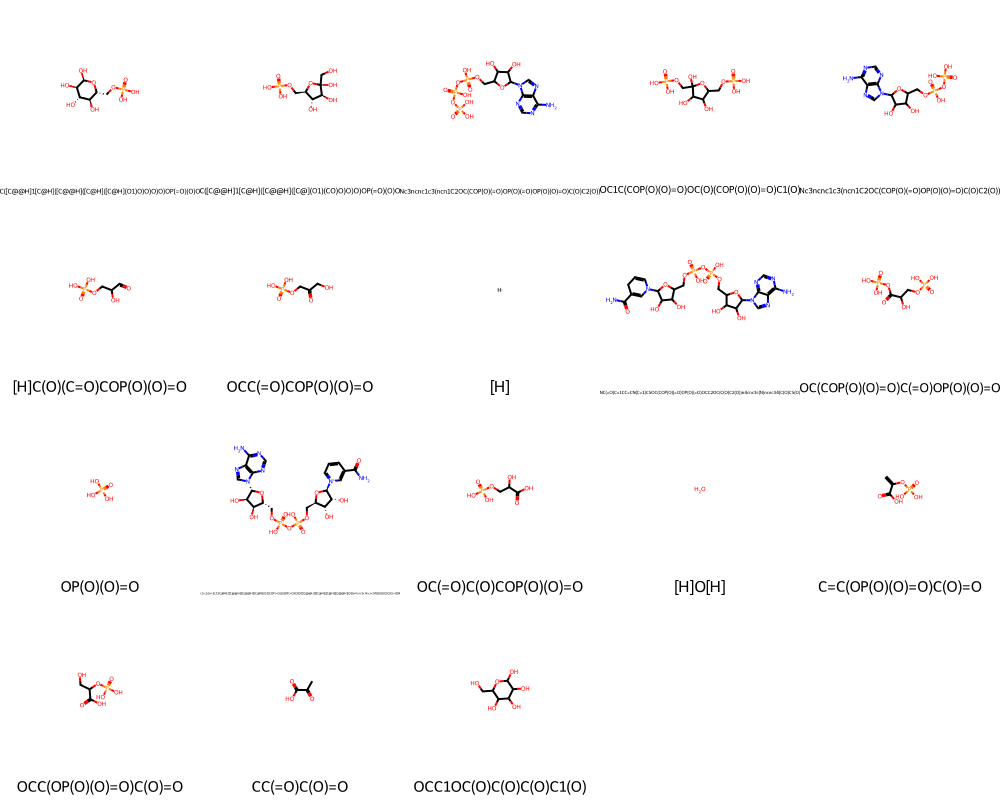

In [6]:

from rdkit.Chem import Draw
mols = df['mol'][:20]

#MolsToGridImage allows to paint a number of molecules at a time
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['Smiles'][:20].values))


In [7]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [33]:

from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors

def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol

#mols = df['mol']

def features(mol,data):
    #Extract properties using RDKit functions
    #mol_name = mol.GetProp('Name')
    smiles = Chem.MolToSmiles(mol)
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mw= Chem.rdMolDescriptors.CalcExactMolWt(mol)
    logp= Crippen.MolLogP(mol)
    num_hbd = Chem.rdMolDescriptors.CalcNumHBD(mol)
    num_hba = Chem.rdMolDescriptors.CalcNumHBA(mol)
    tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
    num_rb = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)

    #Append results in a data list
    data.append([smiles,formula,mw,logp,num_hbd,num_hba,tpsa, num_rb])
    return

data = []

for mol in mols:
    features(mol,data)

#We have a list with information. Creation of a Dataframe:
df= pd.DataFrame(data,columns=['SMILES','Formula','MW','logP',"H-bond donor","H-bond acceptor","TPSA","Rotatable bonds"])
print(df)

                                               SMILES         Formula  \
0   O=P(O)(O)OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@...        C6H13O9P   
1      O=P(O)(O)OC[C@H]1O[C@](O)(CO)[C@@H](O)[C@@H]1O        C6H13O9P   
2   Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...   C10H16N5O13P3   
3              O=P(O)(O)OCC1OC(O)(COP(=O)(O)O)C(O)C1O      C6H14O12P2   
4     Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O   C10H15N5O10P2   
5                                  O=CC(O)COP(=O)(O)O         C3H7O6P   
6                                  O=C(CO)COP(=O)(O)O         C3H7O6P   
7                                                 [H]               H   
8   NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...   C21H29N7O14P2   
9                      O=C(OP(=O)(O)O)C(O)COP(=O)(O)O       C3H8O10P2   
10                                         O=P(O)(O)O           H3O4P   
11  NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...  C21H28N7O14P2+   
12                              O=C(O)C(O)COP(=O)(O